In [3]:
!pip install networkx
!pip install matplotlib
!pip install tqdm

In [18]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations, groupby
import time

In [19]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

builtin_time = []
my_time = []

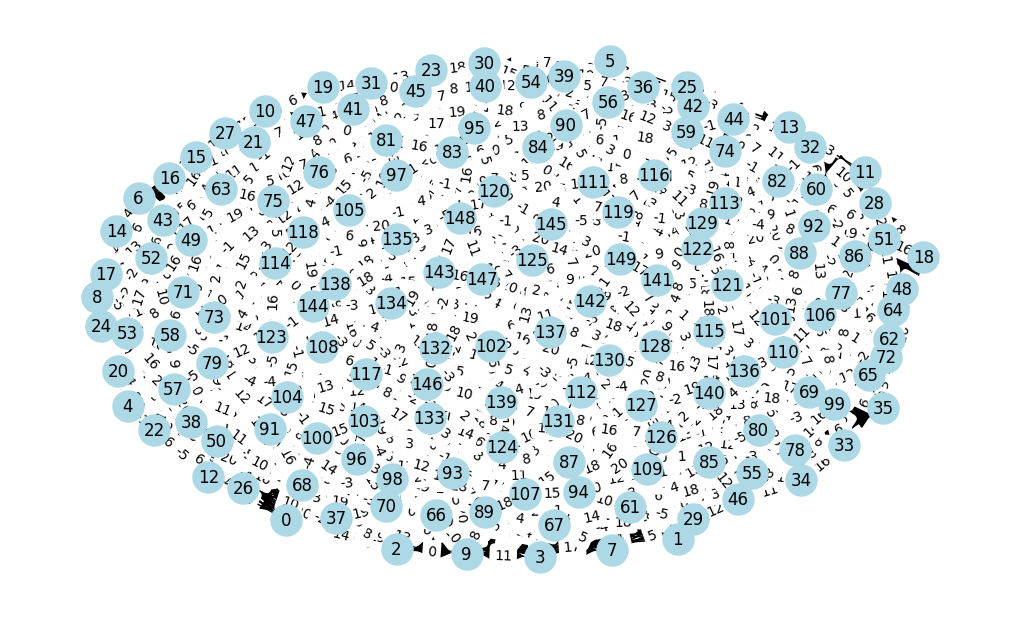

In [50]:
G = gnp_random_connected_graph(150, 0.7, True, True)

In [51]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries

start = time.perf_counter()
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")
end = time.perf_counter()
builtin_time.append(end - start)

Distances with 0 source: {0: -2299089136244530204241971978589962371, 1: -2299089136244530204241971978589962362, 2: -2299089136244530204241971978589962362, 4: -2299089136244530204241971978589962389, 6: -2299089136244530204241971978589962376, 8: -2299089136244530204241971978589962391, 9: -2299089136244530204241971978589962385, 10: -2299089136244530204241971978589962389, 11: -2299089136244530204242004669459973166, 12: -2299089136244530204242004674364932077, 13: -2299089136244530204242004669459973169, 15: -2299089136244530204242004669459973162, 16: -2299089136244530204242004674364932081, 17: -2299089136244530204242004674364932075, 18: -2299089136244530204242004674364932078, 19: -2299089136244530204242004674364932078, 20: -2299089136244530204242004674364932079, 21: -2299089136244530204242004674364932082, 22: -2299089136244530204242004674364932082, 23: -2299089136244530204242004674364932084, 24: -2299089136244530204242004674364932086, 25: -2299089136244530204242004674364932088, 28: -22990891

In [8]:
inf = float('inf')

def generate_mtrx(graph:nx.DiGraph)->list:
    '''
    This function generates a matrix of weights for given weighted graph
    '''
    weighted_mtrx = []
    for node_ in graph.nodes:
        tmp_lst = []
        for neighbor in graph.nodes:
            if neighbor == node_:
                tmp_lst.append(0)
            else:
                try:
                    tmp_lst.append(graph[node_][neighbor]['weight'])
                except KeyError:
                    tmp_lst.append(inf)
        weighted_mtrx.append(tmp_lst.copy())
    return weighted_mtrx

def floyd_warshall_mtrx(mtrx:list)->list:
    '''
    This function does floy_warshall algorythm using matrix of weights given
    '''
    for node_, line in enumerate(mtrx):
        for y, x in enumerate(mtrx):
            if y == node_ or x[node_] == inf:
                continue
            tmp_lst = []
            for ind, w in enumerate(x):
                if ind == y:
                    if (min(x[node_] + line[ind], w)) < 0:
                        return 'Negative cycle detected'
                tmp_lst.append((min(x[node_] + line[ind], w)))
            mtrx[y] = tmp_lst
    return mtrx

def from_lst_dct(mtrx:list)->dict:
    '''
    This function turns our result from list of lists to a dict
    '''
    if isinstance(mtrx, str):
        return mtrx
    res = {}
    for source, dests in enumerate(mtrx):
        weights_dct = {}
        for dest, weight in enumerate(dests):
            weights_dct[dest] = weight
        res[source] = weights_dct
    return res

def floyd_warshall_alg(graph:nx.DiGraph)->dict:
    '''
    This function does floyd_warshall_alg with all the steps inside it
    '''
    return from_lst_dct(floyd_warshall_mtrx(generate_mtrx(graph)))

In [52]:
start = time.perf_counter()
res = floyd_warshall_alg(G)
try:
    for k, v in res.items():
            print(f"Distances with {k} source:", dict(v))
except:
    print(res)
end = time.perf_counter()
my_time.append(end-start)

Negative cycle detected


In [46]:
print(res == dist)

False
[0.0009084999983315356, 0.0013437000015983358, 0.002221900002041366, 0.005896700000448618, 0.009184199996525422, 0.030790700002398808, 0.035961700003099395, 0.1509226000016497]


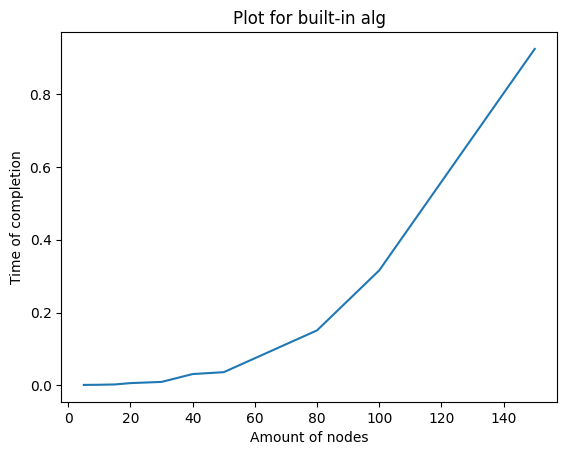

In [56]:
# plot for builtin alg
nodes_amount = [5, 10, 15, 20, 30, 40, 50, 80, 100, 150]
xpoints = np.array(nodes_amount)
ypoints = np.array(builtin_time)

plt.plot(xpoints, ypoints)
plt.title("Plot for built-in alg")
plt.xlabel("Amount of nodes")
plt.ylabel("Time of completion")
plt.show()

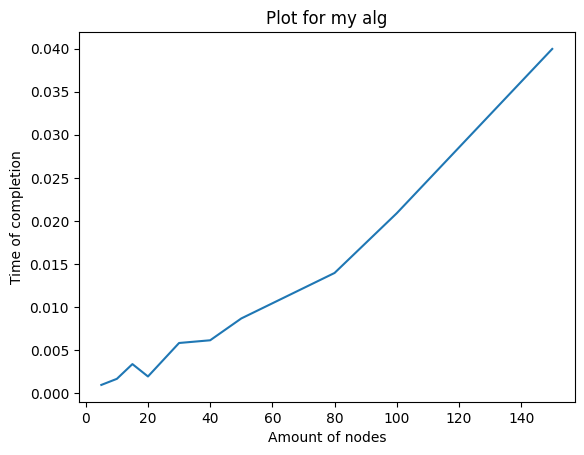

In [55]:
# plot for my alg
nodes_amount = [5, 10, 15, 20, 30, 40, 50, 80, 100, 150]
xpoints = np.array(nodes_amount)
ypoints = np.array(my_time)

plt.plot(xpoints, ypoints)
plt.title("Plot for my alg")
plt.xlabel("Amount of nodes")
plt.ylabel("Time of completion")
plt.show()

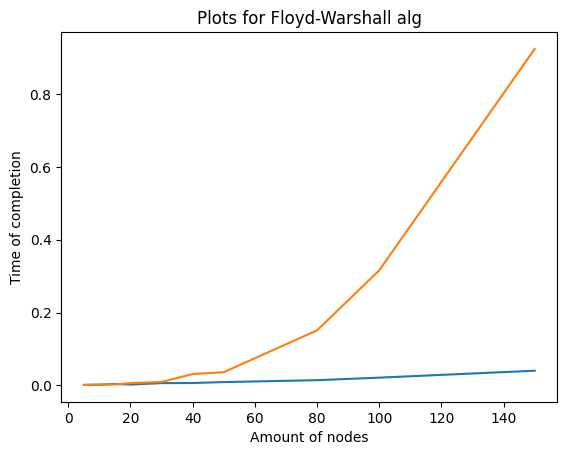

In [58]:
# plot for my alg
nodes_amount = [5, 10, 15, 20, 30, 40, 50, 80, 100, 150]
xpoints = np.array(nodes_amount)
ypoints_my = np.array(my_time)
ypoints_built = np.array(builtin_time)

plt.plot(xpoints, ypoints_my)
plt.plot(xpoints, ypoints_built)
plt.title("Plots for Floyd-Warshall alg")
plt.xlabel("Amount of nodes")
plt.ylabel("Time of completion")
plt.show()